# Experiments
This is where all data cleaning, feature selection, feature engineering, model building, and model evaluation will happen.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

## Functions
Here I will define all the functions that are to be used in this project. There will be 2 categories of functions:
1) Data cleaning functions: These are functions that help handle inconsistencies as discovered in analysis.ipynb.
2) Flagging functions: These are functions that return a list of ids of people who have potentially violated some logic as also discovered in analysis.ipynb.

In [16]:
def clean_age(df: pd.DataFrame, age_threshold: int = 100) -> pd.DataFrame:
    df.loc[df['person_age'] > age_threshold, 'person_age'] -= age_threshold
    return df

def clean_emp_length_by_age(df: pd.DataFrame, age_threshold: int = 100) -> pd.DataFrame:
    violaters = df[df['person_emp_length']>=100].index
    df.drop(violaters, axis=0, inplace=True)
    return df

def clean_underage_or_impossible_labor(df: pd.DataFrame, min_age_of_employment: int) -> pd.DataFrame:
    # Find the age of when the applicant first started working
    df['age_of_first_emp'] = df['person_age'] - df['person_emp_length']

    # Find applicants that started working before the min age and take the difference
    diff = 14 - df[df['age_of_first_emp'] < min_age_of_employment]['age_of_first_emp']

    # Subtract diff from person_emp_length
    df.loc[diff.index, 'person_emp_length'] = df.loc[diff.index, 'person_emp_length'] - diff

    # Verify results
    df['age_of_first_emp'] = df['person_age'] - df['person_emp_length']
    if len(df[df['age_of_first_emp']<min_age_of_employment]) != 0:
        raise ValueError(f"There exist an applicant that started working before they turned {min_age_of_employment}")

    # Drop age_of_first_emp
    df.drop("age_of_first_emp", axis=1, inplace=True)

    return df

def clean_loan_pct_income(df: pd.DataFrame) -> pd.DataFrame:
    df['loan_percent_income'] = round(df['loan_amnt'] / df['person_income'], 2)
    return df

def clean_credit_history(df: pd.DataFrame, min_age_for_credit: int) -> pd.DataFrame:
    # Find age of when the applicant started their credit history
    df['years_from_min_credit_age'] = df['person_age'] - min_age_for_credit

    # Find applicant that started their credit history prior to the min age and take the difference
    diff = df[df['years_from_min_credit_age'] < df['cb_person_cred_hist_length']]

    # Assign years_from_min_credit_age to cb_person_cred_hist_length
    df.loc[diff.index, 'cb_person_cred_hist_length'] = df.loc[diff.index, 'years_from_min_credit_age']

    # Verify results
    if len(df[(df['person_age'] - df['cb_person_cred_hist_length']) < min_age_for_credit]) != 0:
        raise ValueError(f"There exist an applicant that started their credit history before they turned {min_age_for_credit}")

    # Drop years_from_min_credit_age
    df.drop("years_from_min_credit_age", axis=1, inplace=True)

    return df

def flag_no_emp_high_income(df: pd.DataFrame) -> List[int]:
    return list(df[(df['person_emp_length']==0) & (df['person_income']>0)]['id'])

def flag_min_emp_age_violation(df: pd.DataFrame) -> List[int]:
    return df[df['person_age'] - df['person_emp_length'] < 14]['id']

def flag_inconsistent_loan_percentage(df: pd.DataFrame) -> List[int]:
    actual_loan_percent_income = round(df['loan_amnt'] / df['person_income'], 2)
    inconsistent_percentages_df = df.iloc[df['loan_percent_income'].compare(actual_loan_percent_income).index]

    return inconsistent_percentages_df['id']

def flag_credit_history_violation(df: pd.DataFrame, min_age_for_credit: int) -> List[int]:
    df['years_from_min_age'] = df['person_age'] - min_age_for_credit
    credit_history_violaters_df = df[df['years_from_min_age'] < df['cb_person_cred_hist_length']]

    df.drop("years_from_min_age", axis=1, inplace=True)

    return credit_history_violaters_df

## Clean data
Before we begin experimenting, lets first clean both the training set and testing set so we have some consistency. The reason we're cleaning it through this method is because these data cleaning techniques real world interpretation of the data (despite the data being synthetically generated). After cleaning, we will begin experimenting.

In [17]:
# Clean train data
df_train = clean_age(df_train, 100)
df_train = clean_emp_length_by_age(df_train, 100)
df_train = clean_underage_or_impossible_labor(df_train, 14)
df_train = clean_loan_pct_income(df_train)
df_train = clean_credit_history(df_train, 18)

# Clean test data
df_test = clean_age(df_test, 100)
df_test = clean_emp_length_by_age(df_test, 100)
df_test = clean_underage_or_impossible_labor(df_test, 14)
df_test = clean_loan_pct_income(df_test)
df_test = clean_credit_history(df_test, 18)

# Store train ids
train_ids = df_train['id']
df_train.drop('id', axis=1, inplace=True)

# Store test_ids
test_ids = df_test['id']
df_test.drop('id', axis=1, inplace=True)

## Experiment Procedure
Now that the data has been cleaned, lets walk through the different settings that will be tested.

* Categorical Features
    * One-Hot Encoding vs Label Encoding
    * Feature combinations - especially for loan_grade and person_home_ownership
* Outliers
    * Keep vs Drop
* Normalization
    * Log-Transform
    * Box-Cox
* Models
    * Logistic Regression (Baseline)
    * Decision Tree
    * Random Forest
    * AdaBoost
    * CatBoost
    * XGBoost

Lets use PyCaret to automate the experimental process.

In [18]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
s.setup(df_train, target = 'loan_status', session_id = 123)

,Description,Value
0,Session id,123
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(58643, 12)"
4,Transformed data shape,"(58643, 26)"
5,Transformed train set shape,"(41050, 26)"
6,Transformed test set shape,"(17593, 26)"
7,Numeric features,7
8,Categorical features,4
9,Preprocess,True


In [19]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9510,0.9556,0.7195,0.9186,0.8069,0.7793,0.7870,0.7370
rf,Random Forest Classifier,0.9502,0.9322,0.7098,0.9225,0.8023,0.7743,0.7830,0.7410
xgboost,Extreme Gradient Boosting,0.9499,0.9521,0.7300,0.8996,0.8059,0.7775,0.7831,0.2530
gbc,Gradient Boosting Classifier,0.9490,0.9406,0.7089,0.9139,0.7984,0.7698,0.7780,1.4700
et,Extra Trees Classifier,0.9436,0.9178,0.6841,0.8952,0.7755,0.7439,0.7527,0.7240
ada,Ada Boost Classifier,0.9241,0.9219,0.6169,0.8047,0.6983,0.6558,0.6634,0.4340
dt,Decision Tree Classifier,0.9110,0.8284,0.7129,0.6785,0.6952,0.6431,0.6434,0.1310
lr,Logistic Regression,0.9029,0.8957,0.4555,0.7685,0.5718,0.5211,0.5439,1.4770
lda,Linear Discriminant Analysis,0.9021,0.8926,0.5705,0.6887,0.6238,0.5681,0.5716,0.1640
ridge,Ridge Classifier,0.8972,0.8926,0.4355,0.7343,0.5465,0.4927,0.5143,0.0900


In [20]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


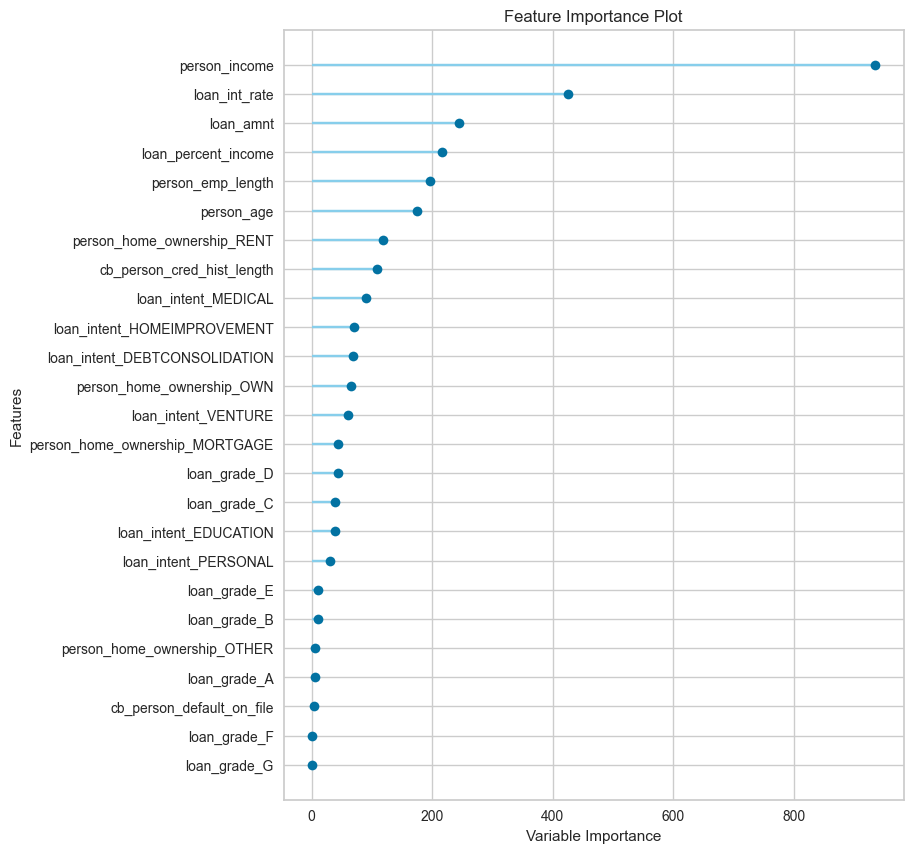

In [21]:
s.plot_model(best, plot = 'feature_all')

In [22]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9515,0.9544,0.7194,0.9227,0.8084,0.7811,0.7891


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,prediction_label,prediction_score
55056,37,34000,MORTGAGE,15.0,DEBTCONSOLIDATION,D,11500,14.91,0.34,N,16,1,1,0.8909
5460,25,80000,MORTGAGE,10.0,PERSONAL,A,12000,6.99,0.15,N,2,0,0,0.9941
52552,33,29280,MORTGAGE,4.0,DEBTCONSOLIDATION,A,1500,8.90,0.05,N,5,0,0,0.9525
57859,22,66000,RENT,4.0,VENTURE,B,24000,12.21,0.36,N,2,1,1,0.9098
16519,27,38000,OWN,11.0,HOMEIMPROVEMENT,E,11000,17.74,0.29,Y,8,0,0,0.8617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20407,30,50000,MORTGAGE,14.0,HOMEIMPROVEMENT,A,3000,7.14,0.06,N,5,0,0,0.9946
28612,22,57000,RENT,4.0,VENTURE,B,13000,11.49,0.23,N,2,0,0,0.9635
40635,33,53000,OWN,6.0,VENTURE,A,3000,7.51,0.06,N,7,0,0,0.9991
53627,26,52800,RENT,1.0,MEDICAL,D,8000,15.37,0.15,Y,3,1,1,0.9508


In [23]:
predictions = s.predict_model(best, data=df_test)
predictions.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,prediction_label,prediction_score
0,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.760000,0.36,N,2,1,0.9781
1,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.680000,0.10,Y,4,0,0.9807
2,26,30000,RENT,5.0,VENTURE,E,4000,17.190001,0.13,Y,2,0,0.5599
3,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.900000,0.14,N,7,0,0.9899
4,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.320000,0.15,Y,4,0,0.9104


In [26]:
s.get_config("X_train_transformed").columns

Index(['person_age', 'person_income', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_RENT', 'person_home_ownership_OWN',
       'person_home_ownership_OTHER', 'person_emp_length',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_MEDICAL', 'loan_intent_EDUCATION', 'loan_intent_VENTURE',
       'loan_intent_PERSONAL', 'loan_grade_B', 'loan_grade_C', 'loan_grade_A',
       'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')